In [10]:
import seaborn as sns
from transformers import BartTokenizer, BartForConditionalGeneration, AdamW
from datasets import load_dataset
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import torch
import random

import numpy as np

def normalize(vector):
    norm = np.linalg.norm(vector)
    if norm == 0: 
        return vector
    return vector / norm


# Load the dataset
dataset = load_dataset('bigscience/P3', 'ai2_arc_ARC_Challenge_pick_the_most_correct_option')
train_dataset = dataset['train']

# Initialize the tokenizer and models (one or continuous prompting and other for projected prompting
model_projected = BartForConditionalGeneration.from_pretrained('facebook/bart-large')

tokenizer = BartTokenizer.from_pretrained('facebook/bart-large')

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_projected.to(device)

# Define the prompt basis
prompt_list = [
    "Generate a flowchart to visually represent the logic needed to answer the question",
    "Write pseudocode for an algorithm that could determine the answer", 
    "Imagine you are explaining the answer to a 5-year-old. Use simple words and analogies.",
    "Summarize the key insights needed to answer in a short poem",
    "Draw a concept map connecting all ideas relevant to the question",
    "List assumptions you must make to provide an answer. What if those assumptions were different?",
    "Compare and contrast multiple ways to approach the question", 
    "Translate the essence of the question into visual art and describe your interpretation",
    "Act out an exaggerated skit to depict the logic behind the answer",
    "Design a decision tree leading to the final answer",
    "Develop a graphic organizer highlighting relationships between key ideas",
    "Frame the question from different philosophical perspectives and give each perspective's answer", 
    "Outline an experiment that could empirically validate the answer",
    "Write a song conveying the concepts needed to respond accurately",
    "Create a metaphor relating the question to a seemingly unrelated domain",
    "Prototype a computer program to compute the answer algorithmically"
]

print(f'tokenizing prompts')
print(f'prompt list length {len(prompt_list)}')

basis = tokenizer(prompt_list, padding=True, truncation=True, return_tensors='pt').to(device)
basis = model_projected.model.shared(basis.input_ids)

def tokenize_function(example):
    return tokenizer(example['inputs_pretokenized'], truncation=True, padding='max_length')

# Apply the function to the dataset
print('tokenzing dataset')
dataset = dataset.map(tokenize_function, batched=True)
train_dataset = dataset['train']
validation_dataset = dataset['validation']

import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the weight prediction model
class LearnWeights(nn.Module):
    def __init__(self, input_dim, output_dim, dropout_rate=0.5):
        super(LearnWeights, self).__init__()
        self.layer1 = nn.Linear(input_dim, 512)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.layer2 = nn.Linear(512, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.layer3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, output_dim)

    def forward(self, x):
        x = F.relu(self.layer1(x))
        x = self.dropout1(x)
        x = F.relu(self.layer2(x))
        x = self.dropout2(x)
        x = F.relu(self.layer3(x))
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = x.mean(dim=1, keepdim=True)  # Compute the mean across the token dimension and batch dimension
        return x.squeeze(1).mean(dim=0)


# Define the projected prompt
input_dim = 1024

output_dim = len(prompt_list)
learn_weights = LearnWeights(input_dim, output_dim).to(device)
optimizer_projected = AdamW(learn_weights.parameters())

# Training parameters
epochs = 5
batch_size = 4
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

tokenizing prompts
prompt list length 16
tokenzing dataset


Training...
Epoch 1/20, Batch 0/1119
Batch Indices: [324, 325]
Loss: 10.01313591003418
Weights for this question: tensor([-0.1668,  0.0635,  0.0118, -0.0304, -0.0300,  0.0428, -0.0327,  0.0317,
         0.0382,  0.0534, -0.0218, -0.0226, -0.0550, -0.0008, -0.0527,  0.0618],
       device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nIf 100 grams of vinegar and 5 grams of baking soda are poured in a container, a small amount of gas will be produced. What will the final mass of the products be if the gas is trapped in the container?\n\nOptions:\n\n- A: 100 grams\n\n- B: 104 grams\n\n- C: 105 grams\n\n- D: 110 grams\n ', 'Pick the most correct option to answer the following question.\n\nTall plants are dominant to short plants. What is the outcome if two short plants are crossed?\n\nOptions:\n\n- A: all tall plants\n\n- B: all short plants\n\n- C: half tall plants, half short plants\n\n- D: 1/4 tall plants, 1/3 short plant

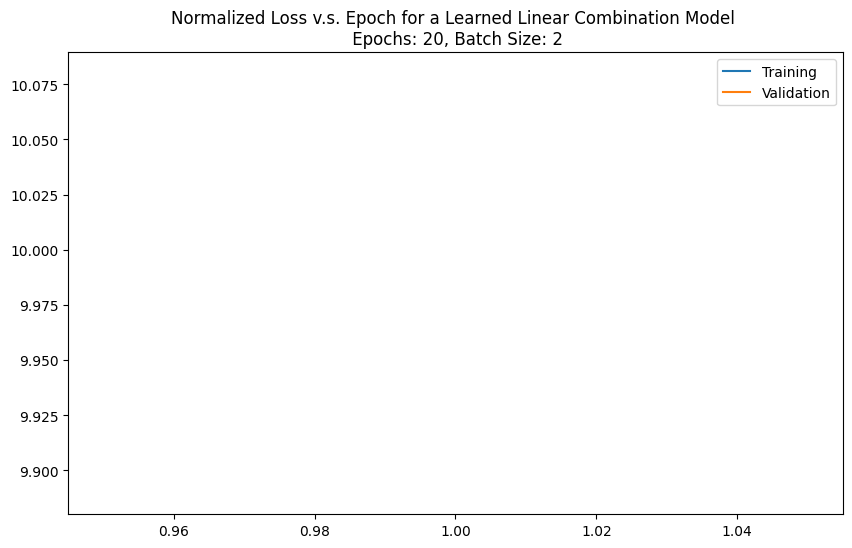

Epoch 2/20, Batch 0/1119
Batch Indices: [394, 395]
Loss: 11.106579780578613
Weights for this question: tensor([-0.5789,  2.0139, -0.7009, -0.7515, -2.1464, -2.9542, -2.7755, -1.5230,
         2.8524, -0.8267, -2.0912,  1.4022, -1.7481, -1.5911,  0.5371,  1.0776],
       device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nWhich diagram best shows how energy flows through a simple food chain?\n\nOptions:\n\n- A: Leaves -> Caterpillar -> Bird\n\n- B: Tree -> Bird -> Caterpillar\n\n- C: Leaves -> Tree -> Caterpillar\n\n- D: Caterpillar -> Leaves -> Bird\n ', "Pick the most correct option to answer the following question.\n\nMrs. Gordon's class studies maple trees. Which property can the students measure with a meter stick?\n\nOptions:\n\n- A: the mass of a leaf\n\n- B: the volume of its sap\n\n- C: the length of a branch\n\n- D: the temperature of its bark\n "]

Epoch 2/20, Batch 200/1119
Batch Indices: [2152, 2153]
Loss: 

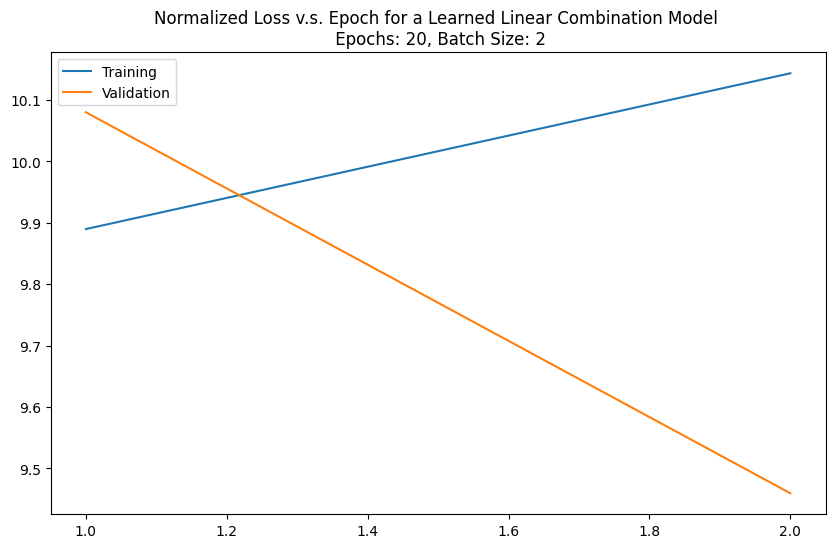

Epoch 3/20, Batch 0/1119
Batch Indices: [1708, 1709]
Loss: 8.071001052856445
Weights for this question: tensor([  1.8757,   9.8344,  -5.0844,  -6.7355,  -5.6080,  -6.6045,  -4.8100,
         -5.4623,   7.4021,  -2.2101, -11.8547,   2.5947,  -0.5559,   0.3290,
          1.8006,   4.6859], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nMarni runs 1500 meters around the school track. What does she need to know in order to find out her speed?\n\nOptions:\n\n- A: her time from start to finish\n\n- B: the number of steps she took\n\n- C: her heart rate at the finish line\n\n- D: the direction she began running\n ', 'Pick the most correct option to answer the following question.\n\nThe liver converts glucose to glycogen for storage. Why is this function considered a chemical change?\n\nOptions:\n\n- A: because the conversion transforms solids to liquids\n\n- B: because the conversion allows for less glucose in the liver\

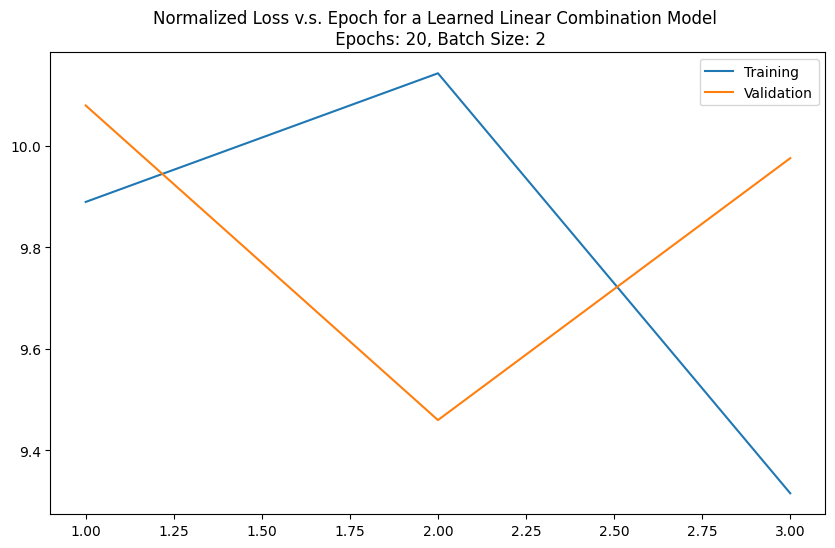

Epoch 4/20, Batch 0/1119
Batch Indices: [966, 967]
Loss: 9.332759857177734
Weights for this question: tensor([ -0.0469,  10.2784,  -7.2565,  -8.1796,  -7.8238, -11.1820,  -6.9193,
         -3.5380,   6.5393,  -2.1240, -11.5337,   4.5941,  -0.4899,  -0.2996,
          6.1421,   2.1761], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nThe human skin plays an important role in a variety of organ systems. Which organ system is least likely to have a direct interaction with the skin?\n\nOptions:\n\n- A: digestive\n\n- B: excretory\n\n- C: immune\n\n- D: nervous\n ', 'Pick the most correct option to answer the following question.\n\nWhat makes solar energy different from most other energy that people use?\n\nOptions:\n\n- A: Solar energy involves the most dangerous equipment.\n\n- B: Solar energy requires the most complicated technology.\n\n- C: The supply of solar energy will not change for billions of years.\n\n- D: Th

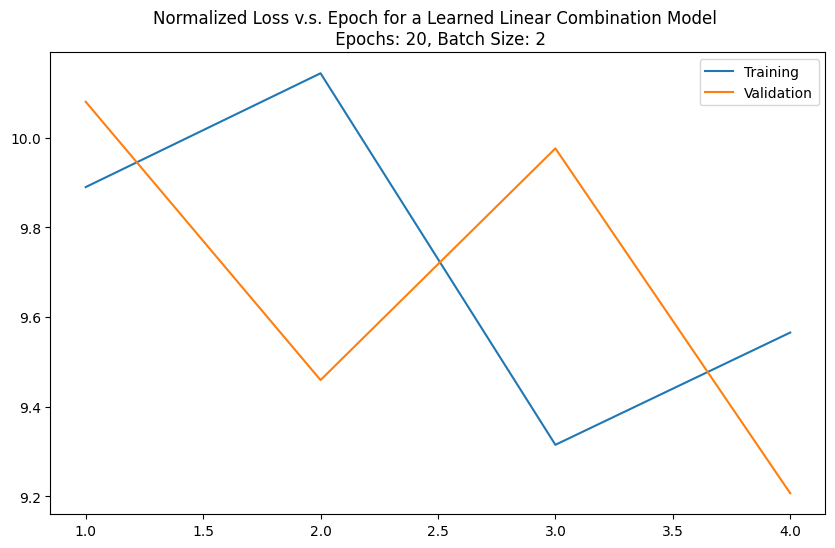

Epoch 5/20, Batch 0/1119
Batch Indices: [2022, 2023]
Loss: 9.122786521911621
Weights for this question: tensor([ 2.4397,  8.1793, -4.1556, -8.9643, -6.6133, -5.8242, -3.1318, -7.0934,
         4.8714, -2.3777, -8.3894,  1.1115,  0.3907,  0.8298,  7.1118,  1.9346],
       device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nWhich of these tools would be best to use when observing insects in a field?\n\nOptions:\n\n- A: compass\n\n- B: hand lens\n\n- C: microscope\n\n- D: thermometer\n ', 'Pick the most correct option to answer the following question.\n\nWhich of the following is a function of the motor neurons in the nervous system?\n\nOptions:\n\n- A: to directly apply force to the skeletal system\n\n- B: to gather information about the stimuli\n\n- C: to transmit messages from the brain to the body\n\n- D: to directly control the action of muscles\n ']

Epoch 5/20, Batch 200/1119
Batch Indices: [130, 131]
Loss: 8.34040

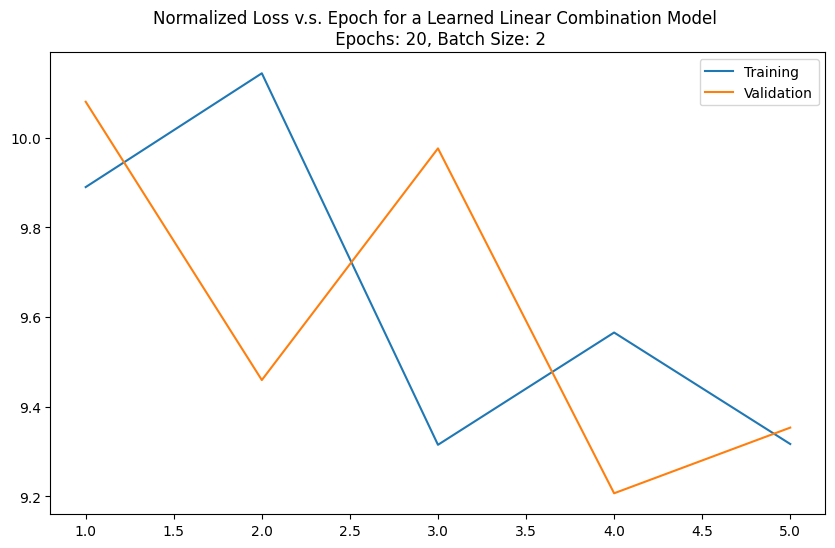

Epoch 6/20, Batch 0/1119
Batch Indices: [1700, 1701]
Loss: 8.973493576049805
Weights for this question: tensor([  4.6428,  13.8171,  -8.5110, -14.2640, -12.8515, -11.7524,  -5.6236,
        -10.6344,   8.1602,  -7.4089, -11.9755,   2.3698,  -0.8609,   2.1355,
         12.6545,   2.6245], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nCompared to similar-sized gasoline-powered vehicles, electric-gasoline-hybrid vehicles are primarily designed to\n\nOptions:\n\n- A: produce more horsepower.\n\n- B: eliminate greenhouse gas emissions.\n\n- C: operate independently of fossil fuels.\n\n- D: provide better gas mileage.\n ', 'Pick the most correct option to answer the following question.\n\nA student is using descriptions to classify organisms. One organism is described as having sense organs to detect heat, laying eggs to reproduce, using venom for protection, and having the ability to change body temperature with its s

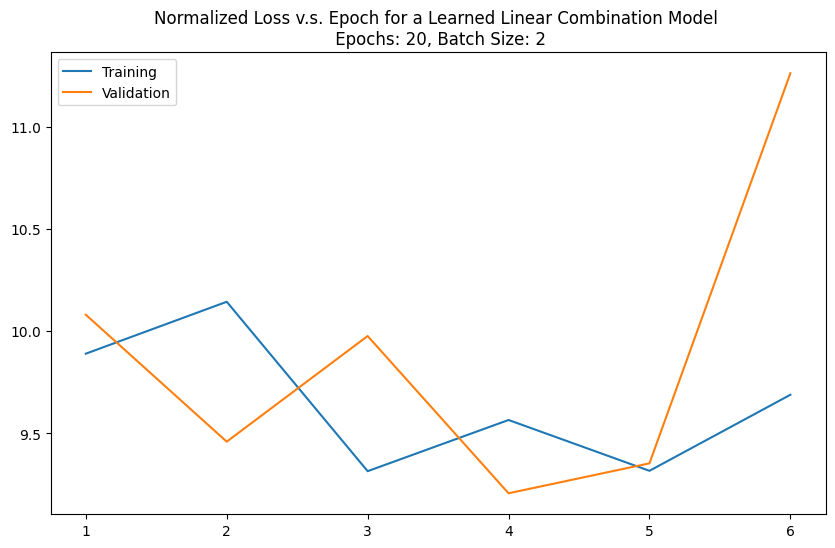

Epoch 7/20, Batch 0/1119
Batch Indices: [2186, 2187]
Loss: 11.39236068725586
Weights for this question: tensor([  3.4255,   4.8547,  -6.5919, -19.4026, -13.3022, -21.7593,  -9.5700,
        -13.0850,  -0.2282, -19.3250,  -3.6894,  -7.5603, -10.0758,   5.1573,
         11.0683,  -4.4251], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nA lake has been used for more than a century to irrigate crops. How has this practice most likely affected this resource?\n\nOptions:\n\n- A: It decreased the salt content of the water.\n\n- B: It increased the evaporation rate of the water.\n\n- C: It increased the number of fish in the lake.\n\n- D: It decreased the volume of the lake.\n ', 'Pick the most correct option to answer the following question.\n\nHuman interaction with the environment has led to increasing amounts of acid rain. Which population have humans adversely affected the most by contributing to the production of ac

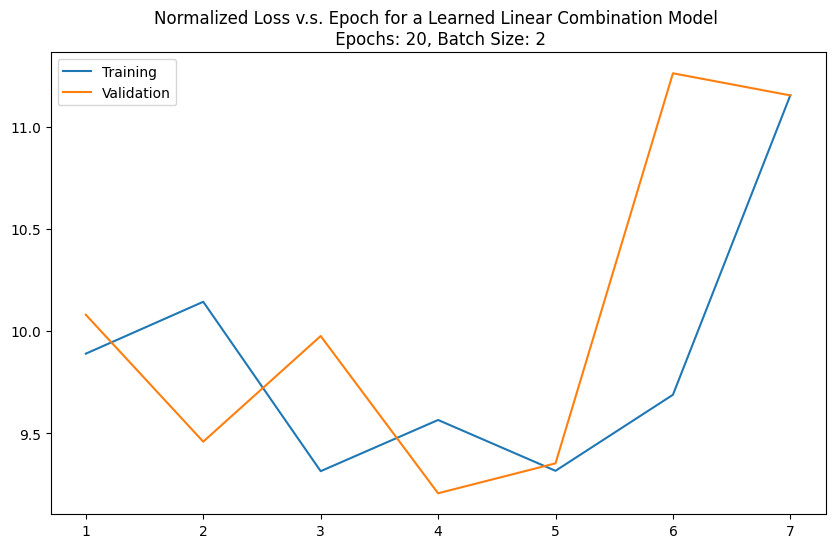

Epoch 8/20, Batch 0/1119
Batch Indices: [1790, 1791]
Loss: 10.92734146118164
Weights for this question: tensor([  3.2366,   5.2467,  -9.5124, -20.8275, -16.2553, -20.7264,  -8.0385,
        -10.2185,  -0.2770, -17.6709,  -3.8281,  -6.5011, -10.7264,  -0.2260,
         12.0565,  -3.5170], device='cuda:0', grad_fn=<MeanBackward1>) question: ["Pick the most correct option to answer the following question.\n\nThe ocean water near the equator absorbs more heat throughout the year than ocean water near the North Pole. Which of the following best explains this difference?\n\nOptions:\n\n- A: The equator is closer to the Sun.\n\n- B: The equator has higher sea levels.\n\n- C: The equator receives more direct sunlight.\n\n- D: The equator rotates more quickly on Earth's axis.\n ", 'Pick the most correct option to answer the following question.\n\nAs a result of rain forest deforestation, some organisms lose their habitats. Which is also an effect of rain forest deforestation?\n\nOptions:\n\n- A

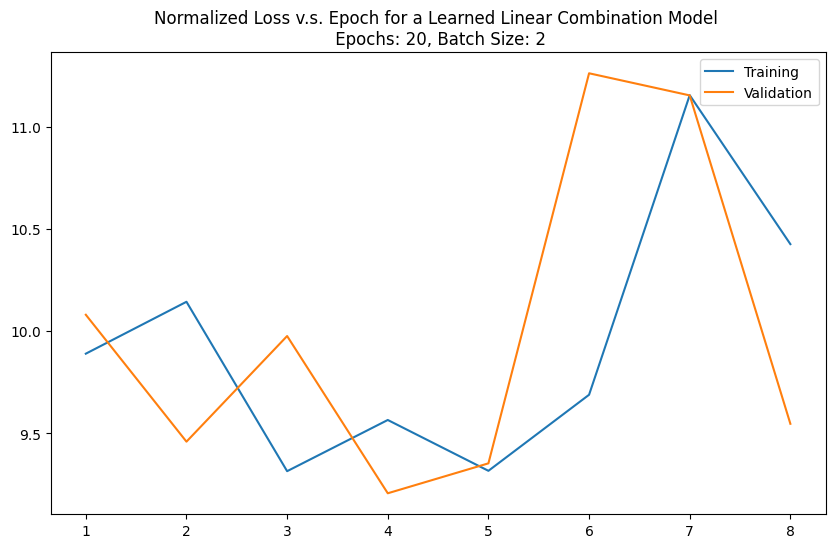

Epoch 9/20, Batch 0/1119
Batch Indices: [734, 735]
Loss: 8.287062644958496
Weights for this question: tensor([ 4.4533e+00,  1.0567e+01, -3.5907e+00, -1.1005e+01, -1.8558e+01,
        -8.6205e+00,  3.1116e+00,  3.3800e+00, -3.3091e-01, -3.2199e+00,
        -2.2266e+00,  4.9208e-03, -7.3175e-02, -3.7899e+00,  1.4337e+01,
        -4.2889e+00], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nVisible light passes through glass. Other types of electromagnetic radiation are able to pass through other materials in a similar way. Which of the following are used in medical technology because they can pass through some parts of the human body?\n\nOptions:\n\n- A: x-rays\n\n- B: infrared waves\n\n- C: microwaves\n\n- D: ultraviolet rays\n ', 'Pick the most correct option to answer the following question.\n\nWhich of the following distinguishes the organisms in the kingdom Fungi from other eukaryotic organisms?\n\nOptions:\n\n-

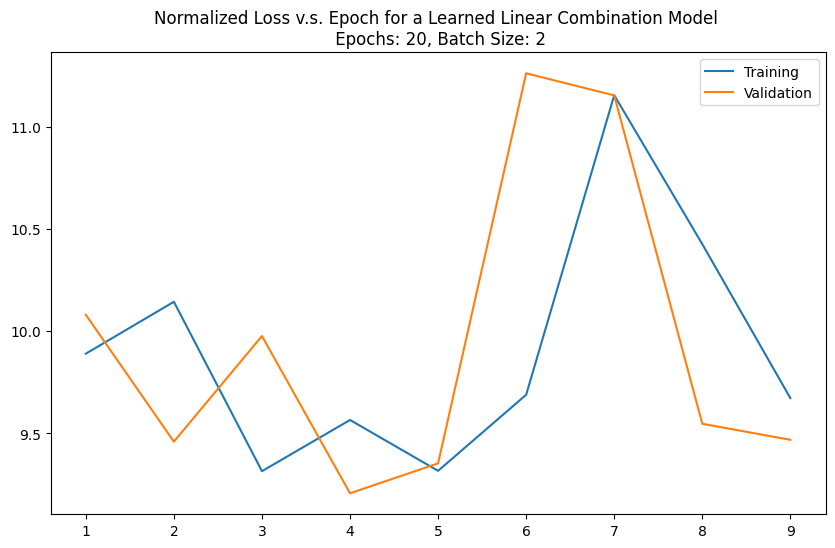

Epoch 10/20, Batch 0/1119
Batch Indices: [1130, 1131]
Loss: 8.507230758666992
Weights for this question: tensor([  9.5608,  52.6115, -19.2160, -13.8369, -32.3162,  11.7374,  29.0270,
         29.0770,   9.5476, -13.3380,  -4.0651,   3.9903,  17.7652,  15.4151,
         38.1214,  10.2760], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nA gasoline is advertised as "releasing fewer pollutants" when it is used in cars. For this claim to be accurate, what has most likely happened to the gasoline?\n\nOptions:\n\n- A: Its acidity has been increased.\n\n- B: More oxygen has been dissolved in it.\n\n- C: Impurities have been removed.\n\n- D: Its molecules have higher chemical energies.\n ', "Pick the most correct option to answer the following question.\n\nVolcanic eruptions early in Earth's history are believed to be responsible for a large proportion of the matter now found in which Earth structure?\n\nOptions:\n\n- A: m

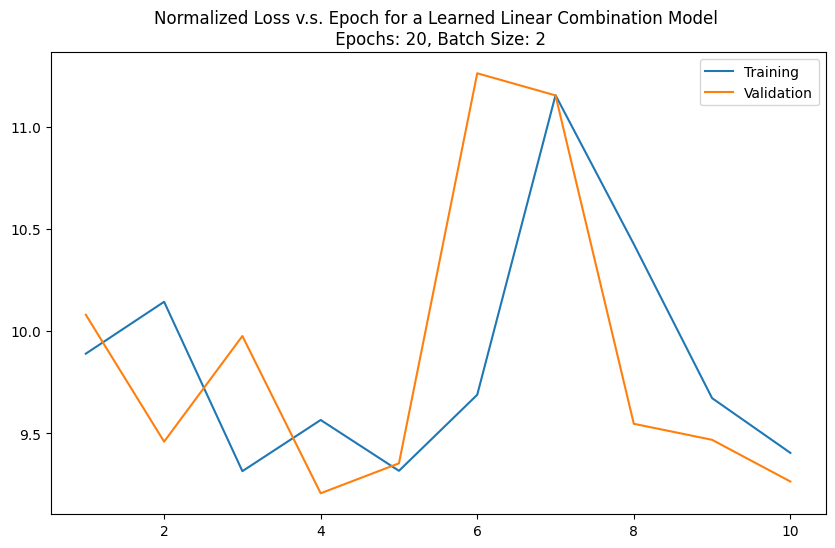

Epoch 11/20, Batch 0/1119
Batch Indices: [2162, 2163]
Loss: 8.11349868774414
Weights for this question: tensor([  8.7194,  61.1802, -18.0767, -13.3784, -38.2949,  14.0830,  34.7281,
         32.9105,  11.6461, -10.4591,  -1.1522,   7.0136,  21.4043,  15.6094,
         43.8050,  14.8830], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nTwo populations of reef fish live in biological coexistence with each other. Which sentence best describes their relationship?\n\nOptions:\n\n- A: The species compete with each other.\n\n- B: One species preys on the other.\n\n- C: The species ignore each other.\n\n- D: One species benefits from the other.\n ', 'Pick the most correct option to answer the following question.\n\nAn exploratory robot was sent to the planet Mars. The gravity on Mars is weaker than the gravity on Earth. Compared to the mass and weight of the robot on Earth, the robot on Mars has\n\nOptions:\n\n- A: less ma

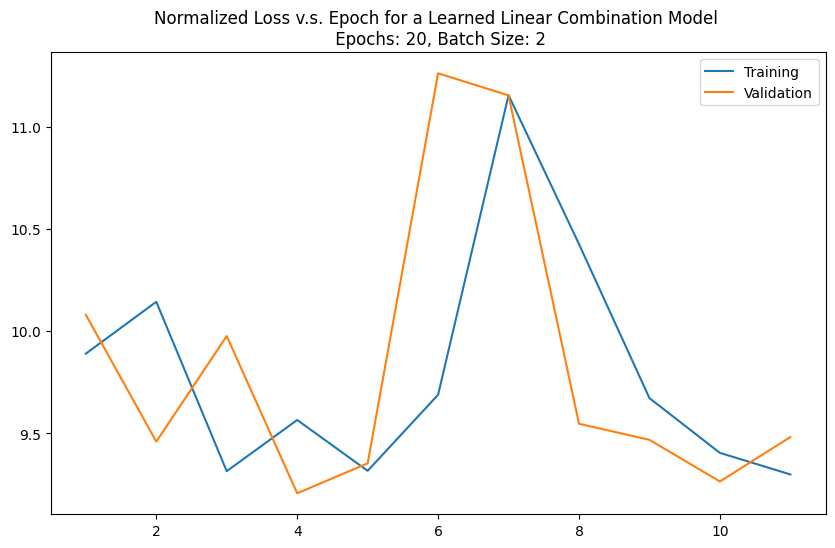

Epoch 12/20, Batch 0/1119
Batch Indices: [864, 865]
Loss: 12.010868072509766
Weights for this question: tensor([  5.0591,  46.7737, -10.8412,  -8.9333, -28.1426,  12.4936,  26.9902,
         25.2346,   9.3093,  -5.5827,   0.3715,   7.7241,  17.5803,  11.6303,
         31.9463,  14.5275], device='cuda:0', grad_fn=<MeanBackward1>) question: ["Pick the most correct option to answer the following question.\n\nWhich upgrade to a school will most likely reduce the school's consumption of nonrenewable resources?\n\nOptions:\n\n- A: solar-collection panels\n\n- B: high-speed computers\n\n- C: wireless Internet connections\n\n- D: biodegradable carpeting\n ", 'Pick the most correct option to answer the following question.\n\nWhat part of the water cycle takes place when water from clouds falls back to Earth?\n\nOptions:\n\n- A: transpiration\n\n- B: evaporation\n\n- C: condensation\n\n- D: precipitation\n ']

Epoch 12/20, Batch 200/1119
Batch Indices: [920, 921]
Loss: 8.12338924407959
Weights f

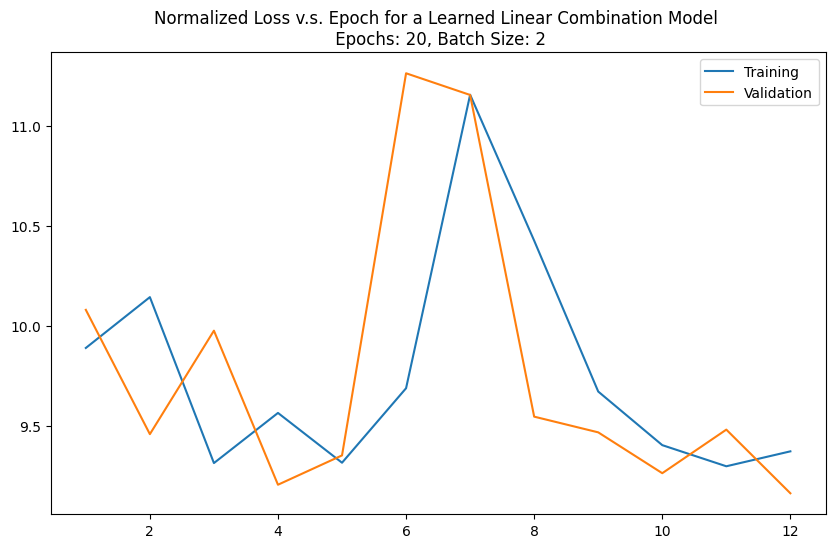

Epoch 13/20, Batch 0/1119
Batch Indices: [1646, 1647]
Loss: 9.500545501708984
Weights for this question: tensor([  6.1682,  66.8242, -14.7155, -11.6419, -35.3899,  23.8195,  38.0378,
         38.0263,  14.9126,  -6.0261,   6.0959,   5.8668,  18.2945,  20.7031,
         44.7662,  22.1529], device='cuda:0', grad_fn=<MeanBackward1>) question: ['Pick the most correct option to answer the following question.\n\nWhich location on Earth has the least intense sunlight on December 22?\n\nOptions:\n\n- A: Equator\n\n- B: Florida\n\n- C: Maine\n\n- D: North Pole\n ', 'Pick the most correct option to answer the following question.\n\nWhen the first American astronauts were planning to walk on the Moon, they knew that the gravity on the Moon was less than the gravity on Earth. With this information, what did the astronauts expect to be most different on the Moon?\n\nOptions:\n\n- A: their mass\n\n- B: their height\n\n- C: their weight\n\n- D: their volume\n ']

Epoch 13/20, Batch 200/1119
Batch Ind

KeyboardInterrupt: 

In [11]:
# Training parameters
epochs = 20
batch_size = 2
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

print('Training...')

# Training loop
projected_losses = []
validation_losses = []

shapes = []


for epoch in range(epochs):
    epoch_loss_projected = 0
    epoch_loss_validation = 0
    for _ in range(0, len(train_dataset), batch_size):
        i = random.randint(0, len(train_dataset) - batch_size + 1 )
        batch = train_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)


        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')


        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)

        # Pass the combined embeddings through the model
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)
 

        loss_projected = outputs_projected.loss
        epoch_loss_projected += loss_projected.item()
        

        optimizer_projected.zero_grad()
        loss_projected.backward(retain_graph=True)
        optimizer_projected.step()

        #print(f'complete from this epoch {i}/{len(train_dataset)}', end='')
        if _ % 200 == 0:
          print(f'Epoch {epoch+1}/{epochs}, Batch {_}/{len(train_dataset)}')
          print(f'Batch Indices: {[i + k for k in range(i, i+batch_size)]}')
          print(f'Loss: {loss_projected.item()}')
          print(f'Weights for this question: {weights} question: {batch["inputs_pretokenized"]}')
          print()

    print('Validating Epoch...')

    for _ in range(0, len(validation_dataset), batch_size):
        i = random.randint(0, len(validation_dataset) - batch_size + 1 )
        batch = validation_dataset[i:i+batch_size]
        if len(batch['inputs_pretokenized']) != batch_size:
          continue
        input_ids = tokenizer(batch['inputs_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)
        labels = tokenizer(batch['targets_pretokenized'], return_tensors='pt', padding=True, truncation=True).input_ids.to(device)

        # Get the prompt input embeddings - same if continuous or projected
        input_embeddings = model_projected.model.shared(input_ids)
        padding_size = max(0, 100 - input_embeddings.shape[1])
        input_embeddings = F.pad(input_embeddings, (0, 0, 0, padding_size), "constant", 0)
        input_embeddings_projected = torch.Tensor(input_embeddings).to(device)

        weights = learn_weights(input_embeddings)
        # print(f'predicted weights' + str(weights))
        # print(f'predicted weights shape' + str(weights.shape))
        # print(f'basis shape' + str(basis.shape))
        # print(f'input embeddings shape' + str(input_embeddings.shape))
        # print(f'soft prompt shape' + str(soft_prompt.shape))
        # print(f'soft prompt batch shape' + str(soft_prompt_batch.shape))
        projected_prompt_batch = weights.unsqueeze(1).unsqueeze(2).expand_as(basis) * basis
        projected_prompt_batch = projected_prompt_batch.sum(dim=0).unsqueeze(0).repeat(batch_size, 1, 1).to(device)
        # print(f'projected prompt batch shape' + str(projected_prompt_batch.shape))
        # print(f'shapes of soft batch and input embeddings: {soft_prompt_batch.shape}, {input_embeddings.shape}')

        combined_projected_embeddings = torch.cat([projected_prompt_batch, input_embeddings_projected], dim=1)
        outputs_projected = model_projected(inputs_embeds=combined_projected_embeddings, labels=labels)

        loss_validation = outputs_projected.loss
        epoch_loss_validation += loss_validation.item()

    epoch_loss_projected /= (len(list(range(0, len(train_dataset), batch_size))))
    epoch_loss_validation /= (len(list(range(0, len(validation_dataset), batch_size))) - 1)

    print(f'Epoch Validation Loss: {epoch_loss_validation} \n', end='')
    print()

    projected_losses.append(epoch_loss_projected)
    validation_losses.append(epoch_loss_validation)

    # Create a DataFrame with the loss values
    n = len(projected_losses)

    # Create the plot
    plt.figure(figsize=(10, 6))
    plt.plot(range(1, n + 1), projected_losses, label='Training')
    plt.plot(range(1, n + 1), validation_losses, label='Validation')
    
    plt.title(f'Normalized Loss v.s. Epoch for a Learned Linear Combination Model \n Epochs: {epochs}, Batch Size: {batch_size}')
    plt.legend()

    # Save the plot as a png file
    print(f'Saveing figure...')
    plt.savefig(f'loss_plot_epoch_{epoch+1}.png')
    plt.show()
